<a href="https://colab.research.google.com/github/Eshan133/Deep-Neural-Network-Scratch-/blob/main/Deep_NN_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

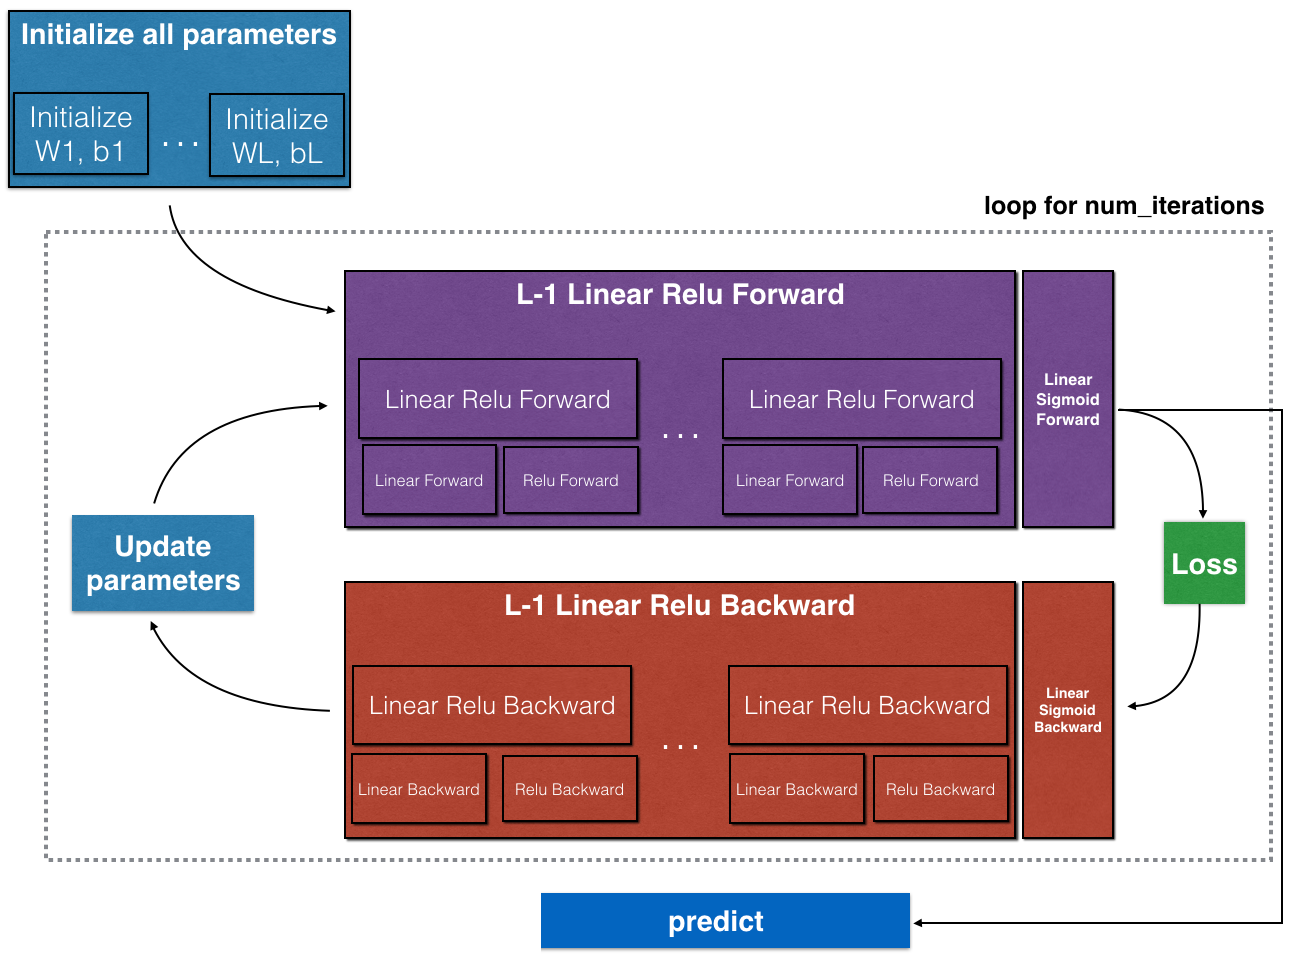

# **Building Deep Neural Network (Step-by-Step)**

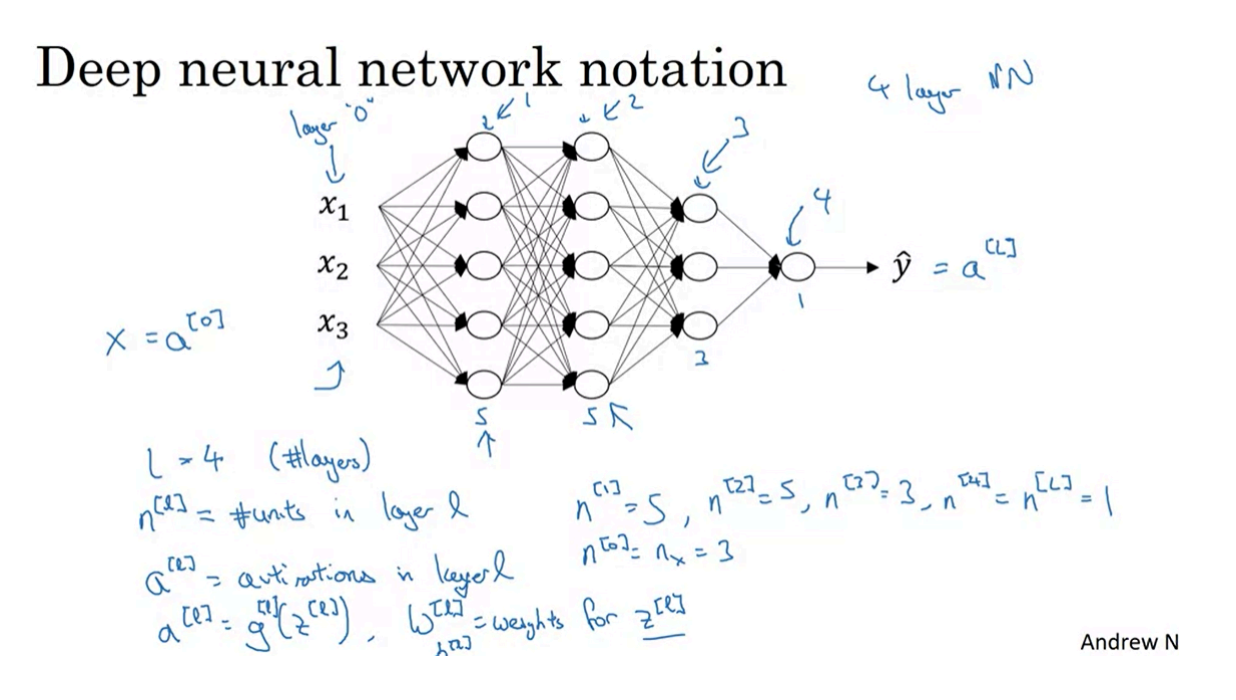

## Package Imports:


In [171]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

---
## Outline
1. Initialize Parameters for Deep Neural Network
2. Forward Propagation Module
3. Compute the loss
4. Back Propagation Module
5. Update the parameters

---
## 1. Initialization

In [172]:
def initialize_parameters(layer_dims):

  np.random.seed(32)
  parameters = {}
  L = len(layer_dims)

  for l in range(1, L):
    parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])
    parameters['b'+str(l)] = np.random.randn(layer_dims[l], 1)

  return parameters

----
## 2. Forward Propagation Module

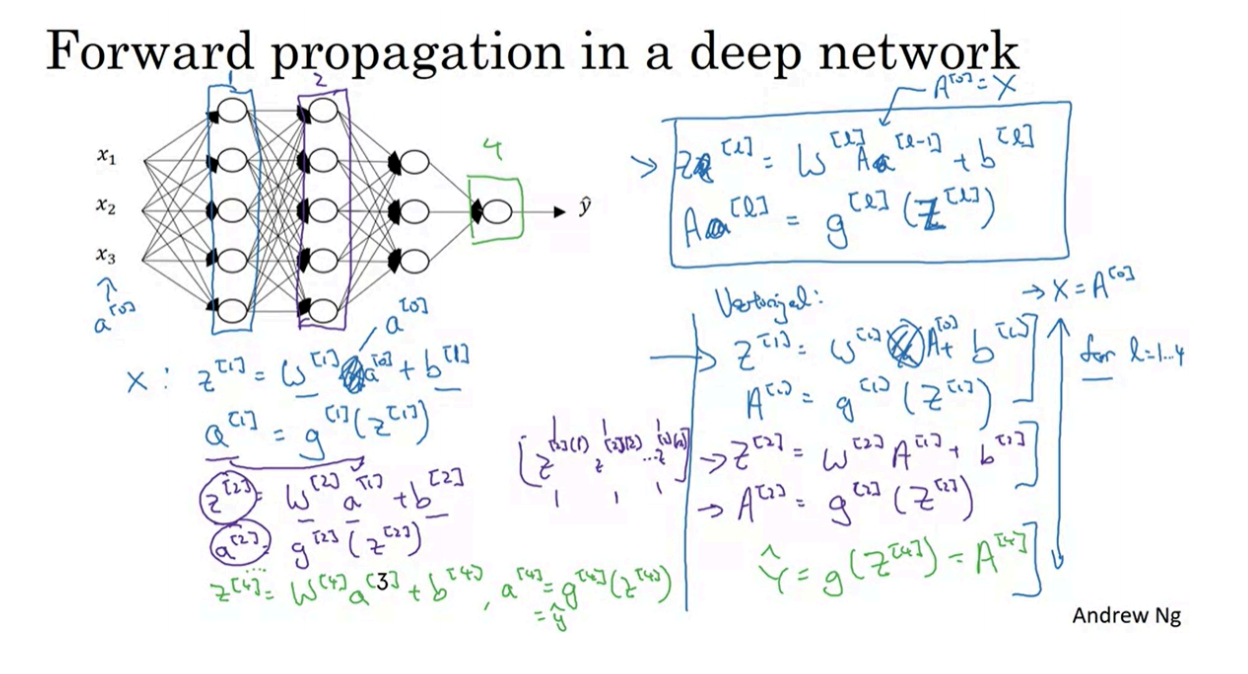

----
### **Cache**

- **linear_cache** = $(A, W, b)$
- **activation_cache** = $Z$
- cache = (**linear_cache**, **activation_cache**)
****

### 2.1 Linear Forward Module
The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

where $A^{[0]} = X$.

In [173]:
def linear_forward(A, W, b):
  Z = np.dot(W,A) + b

  cache = (A, W, b)

  return Z, cache

### 2.2 Forward Activation
- **Sigmoid**: $$\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$$.

- **ReLU**: The mathematical formula for ReLu is, $$A = RELU(Z) = max(0, Z)$$.

In [174]:
def forward_activation(A_prev, W, b, activation):

  Z, linear_cache = linear_forward(A_prev, W, b)

  if(activation == "sigmoid"):
    A = 1/(1+np.exp(-Z))
    activation_cache = Z

  if(activation == "relu"):
    A = np.maximum(0,Z)
    activation_cache = Z

  cache = (linear_cache, activation_cache)
  return A, cache

### 2.3 Forward Propagation
- $AL$ will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.)

In [175]:
def forward_propagation(X, parameters):

  caches = []
  A = X
  L = len(parameters) // 2     ## number of layers, as parameters containes both (W and b)

  # Layers
  for l in range(1,L):
    A, cache = forward_activation(A, parameters['W'+str(l)], parameters['b'+str(l)], activation='relu')
    caches.append(cache)

  # Output Layer
  AL, cache = forward_activation(A, parameters['W'+str(L)], parameters['b'+str(L)], activation='sigmoid')
  caches.append(cache)

  return AL, caches

---
## 3. Cost Function
Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

In [176]:
def compute_cost(AL, Y):
  '''
  AL: Predicted vaues
  Y: True values
  '''

  m,n = Y.shape
  cost = (-1/m)*np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
  cost = np.squeeze(cost)

  return cost

----
## 4. Backpropagation Module

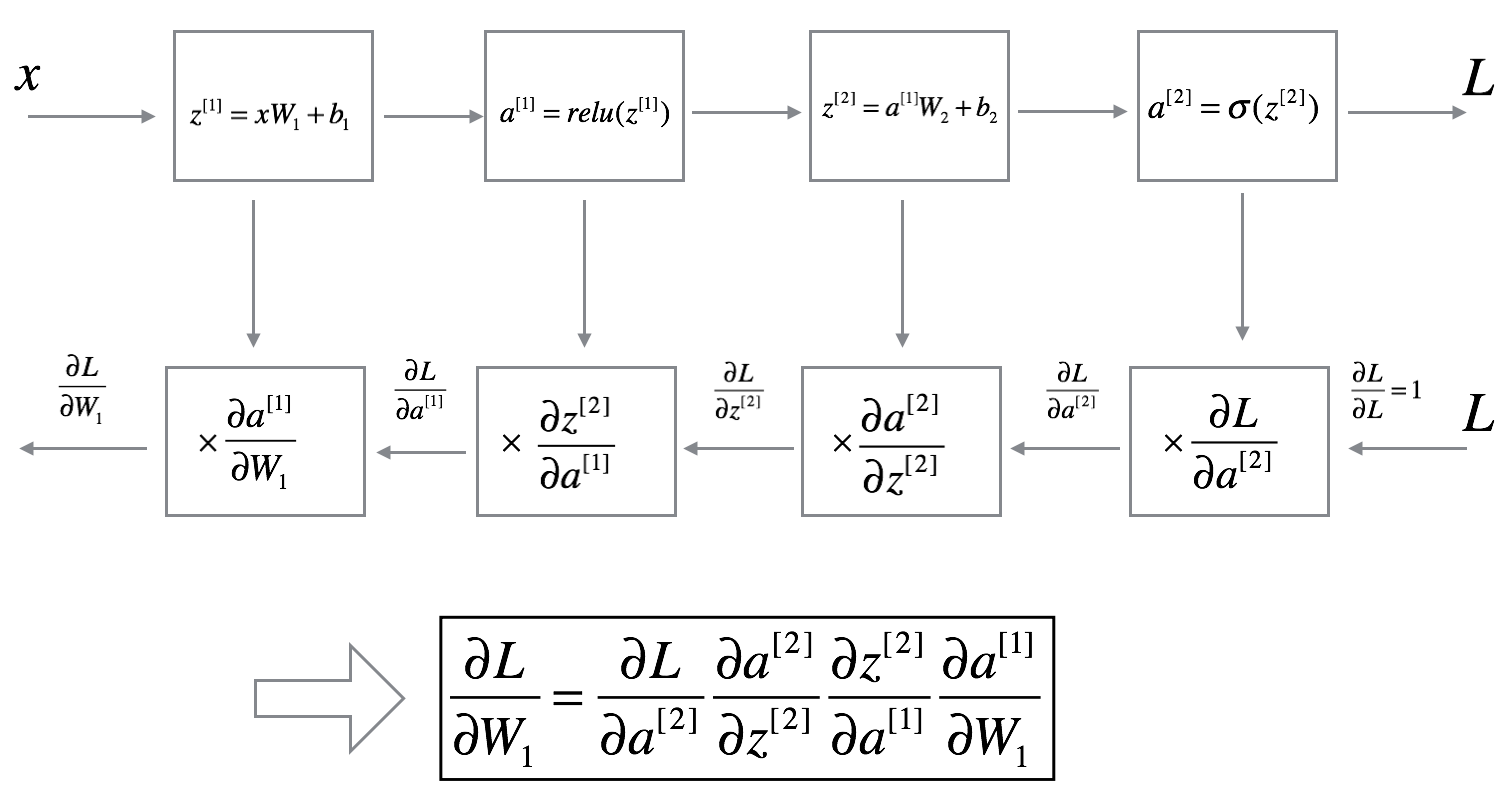

### 4.1 Linear Backprop Module

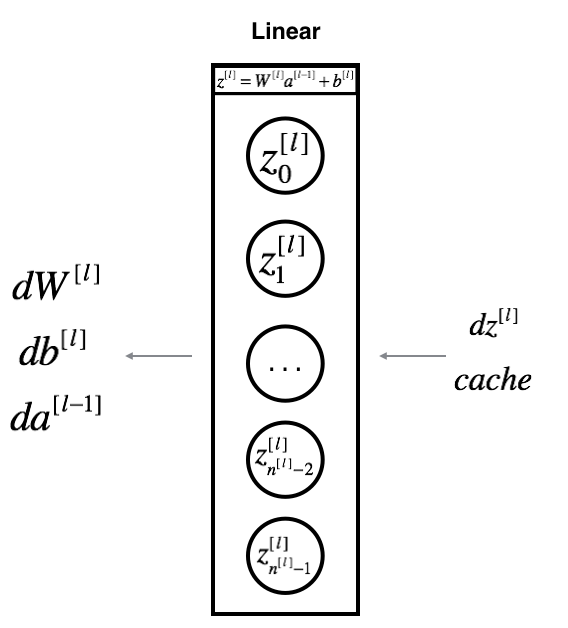

Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$

In [177]:
def linear_backprop(dZ, cache):
  A_prev, W, b = cache
  m,n = A_prev.shape

  dW = (1/m)*np.dot(dZ, A_prev.T)
  db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dZ)

  return dA_prev, dW, db

### 4.2 Relu & Sigmoid Backprop Module

`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$  

In [178]:
def relu_activation(dA, cache):

  Z = cache

  # Initialize dZ same as dA
  dZ = np.array(dA, copy=True)

  dZ[Z <= 0] = 0

  assert (dZ.shape == Z.shape)

  return dZ

In [179]:
def sigmoid_activation(dA, cache):

  Z = cache

  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s)

  assert (dZ.shape == Z.shape)

  return dZ

### 4.3 Activation Backprop Module
- Here, let's put both the backprop module together

In [180]:
def activation_backprop(dA, cache, activation):

  linear_cache, activation_cache = cache

  if(activation == "relu"):
    dZ = relu_activation(dA, activation_cache)
    dA_prev, dW, db = linear_backprop(dZ, linear_cache)

  if(activation == "sigmoid"):
    dZ = sigmoid_activation(dA, activation_cache)
    dA_prev, dW, db = linear_backprop(dZ, linear_cache)

  return dA_prev, dW, db

### 4.4 Backprop Module
- Here, we call backprop module for each layer

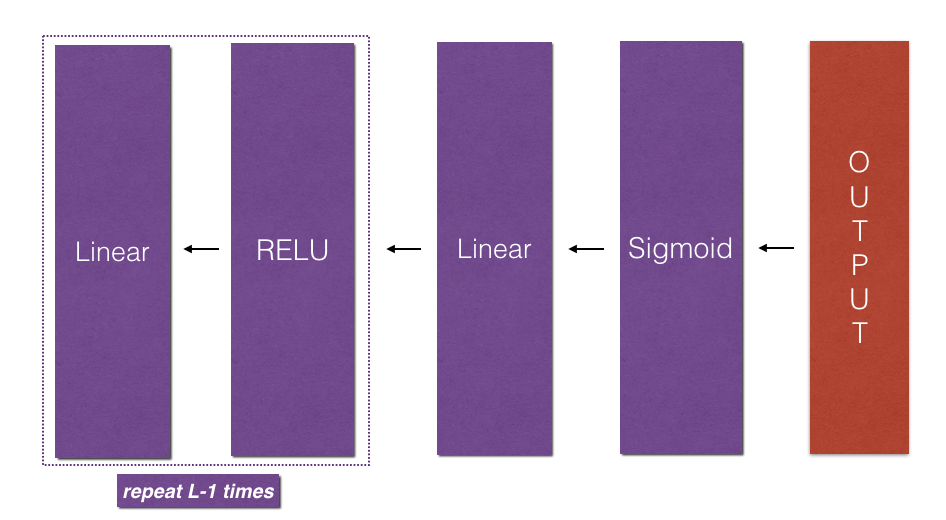

- Initialize the AL, we use the formula:
$$dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))$$
- This is here, the backprop starts

In [181]:
def backward_propagation(AL, Y, cache):

  grad = {}
  m = AL.shape[1]
  L = len(cache)
  Y = Y.reshape(AL.shape)

  dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))

  current_cache = cache[L-1]
  dA_prev, dW, db = activation_backprop(dAL, current_cache, activation='sigmoid')

  grad['dA'+str(L-1)] = dA_prev
  grad['dW'+str(L)] = dW
  grad['db'+str(L)] = db

  for i in reversed(range(L-1)):
    current_cache = cache[i]
    dA_prev, dW, db = activation_backprop(dA_prev, current_cache, activation='sigmoid')
    grad['dA'+str(i)] = dA_prev
    grad['dW'+str(i+1)] = dW
    grad['db'+str(i+1)] = db

  return grad

## 5. Update parameters

Let's update parameters (W,b), using the formulas,
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$
Where,
$\alpha$ is the `learning_rate`

In [182]:
import copy

In [183]:
def update_parameters(params, grads, learning_rate):

  parameters = copy.deepcopy(params)
  L = len(parameters) // 2

  for l in range(L):
    parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
    parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

  return parameters

---
## 6. Passing data into the model

### 6.1 Forward pass

In [184]:
np.random.seed(2)

X = np.random.randn(4,3)
Y = np.asarray([[1, 1, 0]])

W1 = np.random.randn(3,4)
b1 = np.random.randn(3,1)
W2 = np.random.randn(1,3)
b2 = np.random.randn(1,1)

parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}



In [191]:
AL, caches = forward_propagation(X, parameters)

In [185]:
print("AL = " + str(AL))

AL = [[0.09846735 0.25782359 0.43313862]]


### 6.2 Compute Cost

In [193]:
cost = compute_cost(AL, Y)
print("Cost: " + str(cost))

Cost: 4.094372904297547


### 6.3 Backward pass

In [201]:
grad = backward_propagation(AL, Y, caches)

### 6.4 Parameter update

In [203]:
t_parameters = update_parameters(parameters, grad, 0.1)

print ("W1 = "+ str(t_parameters["W1"]))
print ("b1 = "+ str(t_parameters["b1"]))
print ("W2 = "+ str(t_parameters["W2"]))
print ("b2 = "+ str(t_parameters["b2"]))

W1 = [[ 0.03759296 -1.11710432  0.54054899 -0.58966306]
 [-0.02366323  1.16984086 -0.74952601  0.01951367]
 [-0.87810679 -0.15642976  0.25657079 -0.98878608]]
b1 = [[-0.34441237]
 [-0.24205132]
 [-0.63764776]]
W2 = [[-1.16738794 -1.3881388  -0.13263394]]
b2 = [[-0.22764976]]


----
## 7. Putting it all together

Cost:  4.2411503963673045
Cost:  4.099105016040328
Cost:  3.9652442602063234
Cost:  3.8393560357722105
Cost:  3.721196802509756
Cost:  3.6104947928364863
Cost:  3.506953978413127
Cost:  3.4102585856211873
Cost:  3.3200779332224952
Cost:  3.2360713605359184
Cost:  3.155903293785464
Cost:  3.0628768960641244
Cost:  2.9766430638198274
Cost:  2.896652574131442
Cost:  2.822398053101279


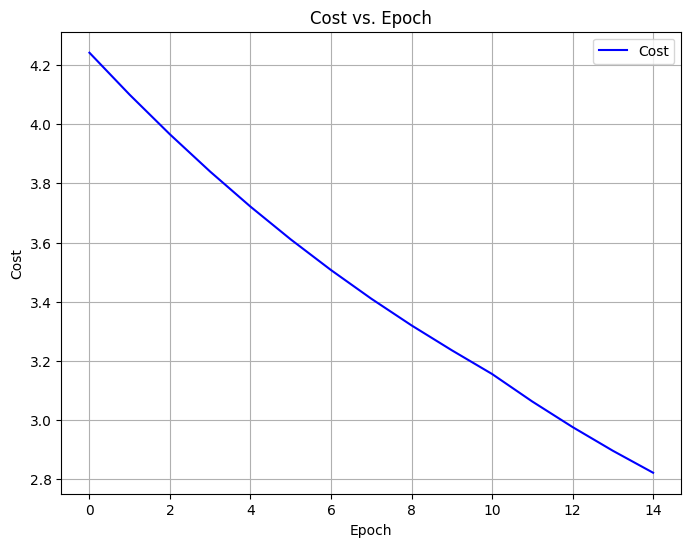

In [209]:
## Initialization
np.random.seed(2)

X = np.random.randn(4,3)
Y = np.asarray([[1, 1, 0]])

W1 = np.random.randn(3,4)
b1 = np.random.randn(3,1)
W2 = np.random.randn(1,3)
b2 = np.random.randn(1,1)

parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}

costs = []
epochs = 15

'''------------------------------------------------------------'''
for epoch in range(epochs):

  # Forward pass
  AL, caches = forward_propagation(X, parameters)

  # Compute cost
  cost = compute_cost(AL, Y)
  costs.append(cost)
  print("Cost: ",cost)

  # Backpropagation
  grad = backward_propagation(AL, Y, caches)

  # Update parameters
  parameters = update_parameters(parameters, grad, 0.1)
'''------------------------------------------------------------'''

# Plotting the cost
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), costs, 'b-', label='Cost')
plt.title('Cost vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()